# Random Acts of Pizza

by Garber Boris, Josiah McDonald and Michael Powers

This competition contains a dataset with 5671 textual requests for pizza from the Reddit community Random Acts of Pizza together with their outcome (successful/unsuccessful) and meta-data. Participants must create an algorithm capable of predicting which requests will garner a cheesy (but sincere!) act of kindness.

https://www.kaggle.com/c/random-acts-of-pizza

## 1. Load Packages and Data

In [1]:
# Do not display warnings, like features being deprecated from future package releases.
import warnings
warnings.filterwarnings('ignore')

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import datetime

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn import mixture

# SK-learn libraries for evaluation.
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

C:\Users\mpowers\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\mpowers\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Data should be in "Data" folder, which should exist in the same location as this notebook
os.chdir('Data')

# load data from json files to df
with open('train.json') as train:
    trainjson = json.load(train)

with open('test.json') as test:
    testjson = json.load(test)
    
df_train = pd.io.json.json_normalize(trainjson)
df_test = pd.io.json.json_normalize(testjson)

In [4]:
# View columns, and data dictionary from Kaggle
df_train.columns

Index(['giver_username_if_known',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_id', 'request_number_of_comments_at_retrieval', 'request_text',
       'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_at_request', 'r

Data dictionary:

"giver_username_if_known": Reddit username of giver if known, i.e. the person satisfying the request ("N/A" otherwise).

"number_of_downvotes_of_request_at_retrieval": Number of downvotes at the time the request was collected.

"number_of_upvotes_of_request_at_retrieval": Number of upvotes at the time the request was collected.

"post_was_edited": Boolean indicating whether this post was edited (from Reddit).

"request_id": Identifier of the post on Reddit, e.g. "t3_w5491".

"request_number_of_comments_at_retrieval": Number of comments for the request at time of retrieval.

"request_text": Full text of the request.

"request_text_edit_aware": Edit aware version of "request_text". We use a set of rules to strip edited comments indicating the success of the request such as "EDIT: Thanks /u/foo, the pizza was delicous".

"request_title": Title of the request.

"requester_account_age_in_days_at_request": Account age of requester in days at time of request.

"requester_account_age_in_days_at_retrieval": Account age of requester in days at time of retrieval.

"requester_days_since_first_post_on_raop_at_request": Number of days between requesters first post on RAOP and this request (zero if requester has never posted before on RAOP).

"requester_days_since_first_post_on_raop_at_retrieval": Number of days between requesters first post on RAOP and time of retrieval.

"requester_number_of_comments_at_request": Total number of comments on Reddit by requester at time of request.

"requester_number_of_comments_at_retrieval": Total number of comments on Reddit by requester at time of retrieval.

"requester_number_of_comments_in_raop_at_request": Total number of comments in RAOP by requester at time of request.

"requester_number_of_comments_in_raop_at_retrieval": Total number of comments in RAOP by requester at time of retrieval.

"requester_number_of_posts_at_request": Total number of posts on Reddit by requester at time of request.

"requester_number_of_posts_at_retrieval": Total number of posts on Reddit by requester at time of retrieval.

"requester_number_of_posts_on_raop_at_request": Total number of posts in RAOP by requester at time of request.

"requester_number_of_posts_on_raop_at_retrieval": Total number of posts in RAOP by requester at time of retrieval.

"requester_number_of_subreddits_at_request": The number of subreddits in which the author had already posted in at the time of request.

"requester_received_pizza": Boolean indicating the success of the request, i.e., whether the requester received pizza.

"requester_subreddits_at_request": The list of subreddits in which the author had already posted in at the time of request.

"requester_upvotes_minus_downvotes_at_request": Difference of total upvotes and total downvotes of requester at time of request.

"requester_upvotes_minus_downvotes_at_retrieval": Difference of total upvotes and total downvotes of requester at time of retrieval.

"requester_upvotes_plus_downvotes_at_request": Sum of total upvotes and total downvotes of requester at time of request.

"requester_upvotes_plus_downvotes_at_retrieval": Sum of total upvotes and total downvotes of requester at time of retrieval.

"requester_user_flair": Users on RAOP receive badges (Reddit calls them flairs) which is a small picture next to their username. In our data set the user flair is either None (neither given nor received pizza, N=4282), "shroom" (received pizza, but not given, N=1306), or "PIF" (pizza given after having received, N=83).

"requester_username": Reddit username of requester.

"unix_timestamp_of_request": Unix timestamp of request (supposedly in timezone of user, but in most cases it is equal to the UTC timestamp -- which is incorrect since most RAOP users are from the USA).

"unix_timestamp_of_request_utc": Unit timestamp of request in UTC.

**Conclusion: The outcome variable requester_received_pizza indicates if the user received pizza or not. The explanatory variables we are interested in using are free text fields that contain the title and text of the written request, as well as other numeric and datetime metadata fields that correspond to the time the request was made ("at_retrieval"). We have decided to ignore variables that correspond to the time of retrieval ("at_retrieval"). We want our algorithms to be trained to predict if someone will receive pizza at the time they make a request.**

## 2. Exploratory Data Analysis

In [5]:
# Do all of the records contain request text?
print("# rows 'request_text' is blank", len(df_train[df_train['request_text']==""]))
print("# rows 'request_text_edit_aware' is blank", len(df_train[df_train['request_text_edit_aware']==""]))
print("# rows 'request_title' is blank", len(df_train[df_train['request_title']==""]))
print("# rows 'request_text_edit_aware' is null", df_train['request_text_edit_aware'].isnull().sum())
print("# rows 'request_title' is null", df_train['request_title'].isnull().sum())
 # All of the records have a title. Sometimes a request is made only using a title.
 # This suggests that we should plan to concatentate the request title and text.

# rows 'request_text' is blank 104
# rows 'request_text_edit_aware' is blank 104
# rows 'request_title' is blank 0
# rows 'request_text_edit_aware' is null 0
# rows 'request_title' is null 0


In [6]:
# None of the potential features have a null value or cotain an empty string
# Request text has empty strings, but we don't include that here because we will ultimately combine this with request title
potential_features = [
'request_title',
'requester_received_pizza',
'requester_account_age_in_days_at_request', 
'requester_days_since_first_post_on_raop_at_request', 
'requester_number_of_comments_at_request', 
'requester_number_of_comments_in_raop_at_request',
'requester_number_of_posts_at_request',
'requester_number_of_posts_on_raop_at_request',
'requester_number_of_subreddits_at_request', 
'requester_upvotes_minus_downvotes_at_request', 
'unix_timestamp_of_request']

print(df_train[potential_features].isnull().sum().sum())

print(np.where(df_train[potential_features].applymap(lambda x: x == '')))

####

0
(array([], dtype=int64), array([], dtype=int64))


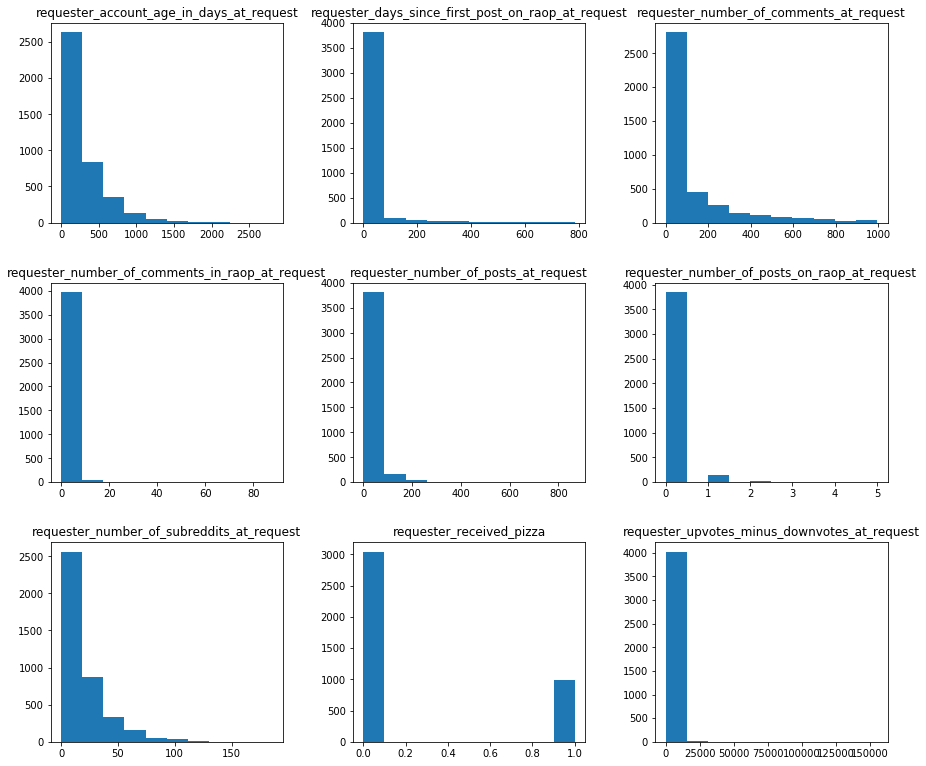

In [7]:
# Histograms of numeric variables
numeric_features = [
'requester_received_pizza',
'requester_account_age_in_days_at_request', 
'requester_days_since_first_post_on_raop_at_request', 
'requester_number_of_comments_at_request', 
'requester_number_of_comments_in_raop_at_request',
'requester_number_of_posts_at_request',
'requester_number_of_posts_on_raop_at_request',
'requester_number_of_subreddits_at_request', 
'requester_upvotes_minus_downvotes_at_request']

hist = df_train[numeric_features].hist(grid=False, layout=(4,3), figsize=(15,18))

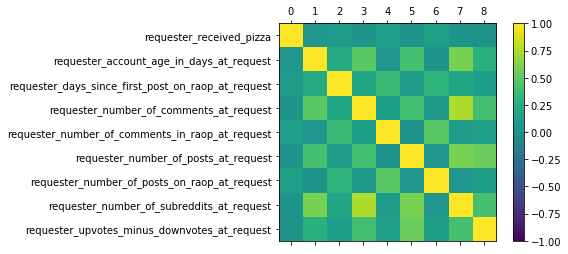

In [8]:
# Correlations
correlations = df_train[numeric_features].corr()

# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
#ax.set_xticklabels(numeric_features)
ax.set_yticklabels(numeric_features)
plt.show()

**Conclusion: None of the numeric metadata seems to be highly correlated with the outcome variable (requester_received_pizza). Most of the distributions appear to be exponential. We will transform these variables in order to obtain more normal distributions.**

## 3. Data Preparation

**For each numeric feature with an exponential distribution, create a new field with the log transformation.**

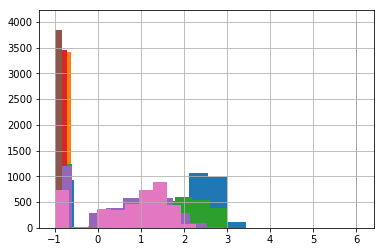

In [3]:
# For each numeric feature, create a new field with the log transformation.
numeric_features = [
'requester_account_age_in_days_at_request', 
'requester_days_since_first_post_on_raop_at_request', 
'requester_number_of_comments_at_request', 
'requester_number_of_comments_in_raop_at_request',
'requester_number_of_posts_at_request',
'requester_number_of_posts_on_raop_at_request',
'requester_number_of_subreddits_at_request', 
'requester_upvotes_minus_downvotes_at_request']

for nf in numeric_features:
    # Since "upvotes minus downvotes" can contain negative values. Add 1,000,000 to ensure no negatives.
    # Because the log of negative is undefined
    if nf == 'requester_upvotes_minus_downvotes_at_request':
        df_train[nf + '_LOG'] = np.log10(df_train[nf]+1000000)
        np.log10(df_train[nf]+1000000).hist()
    else:
        df_train[nf + '_LOG'] = np.log10(df_train[nf]+0.1)
        np.log10(df_train[nf]+0.1).hist()

**Split data sets into train/dev/test, using a 60/20/20 split respectively. Since the test data does not indicate whether a pizza was received, we will split the training data in order to obtain a labeled test set.**

In [4]:
# randomize and split data set into train, dev and test using 60/20/20 split
np.random.seed(33)
shuffle = np.random.permutation(np.arange(df_train.shape[0]))
df_train_data, df_train_labels = df_train.ix[shuffle, :], df_train.ix[shuffle, 'requester_received_pizza']

cutoff1 = int(df_train_labels.shape[0]*0.6)
cutoff2 = int(df_train_labels.shape[0]*0.8)
train_data, train_labels = df_train_data[:cutoff1], df_train_labels[:cutoff1]
dev_data, dev_labels = df_train_data[cutoff1:cutoff2], df_train_labels[cutoff1:cutoff2]
test_mini_data, test_mini_labels = df_train_data[cutoff2:], df_train_labels[cutoff2:]

print ('train data shape: ', train_data.shape)
print ('dev data shape:', dev_data.shape)
print ('test data shape:', test_mini_data.shape)

train data shape:  (2424, 40)
dev data shape: (808, 40)
test data shape: (808, 40)


## 4. Predictive Modeling

### 4.1 Baseline Model - Numeric Metadata Features

##### Logistic Regression Model

In [11]:
# Numeric features for baseline model
numeric_features = [
'requester_account_age_in_days_at_request_LOG', 
'requester_days_since_first_post_on_raop_at_request_LOG', 
'requester_number_of_comments_at_request_LOG', 
'requester_number_of_comments_in_raop_at_request_LOG',
'requester_number_of_posts_at_request_LOG',
'requester_number_of_posts_on_raop_at_request_LOG',
'requester_number_of_subreddits_at_request_LOG', 
'requester_upvotes_minus_downvotes_at_request_LOG' 
]

# Logisitic modeling - numeric features
log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(dev_data[numeric_features], dev_labels)

log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(train_data[numeric_features], train_labels)
log_clf_best_predicted = log_clf_best.predict(test_mini_data[numeric_features])
fpr, tpr, _ = metrics.roc_curve(test_mini_labels, log_clf_best_predicted)

print('----- Logistic Regression -----')
print (log_gs.best_params_)
accuracy = accuracy_score(log_clf_best_predicted, test_mini_labels) * 100
print ('Logistic accuracy: {:2.5f}%'.format(accuracy))
print ('Logistic accuracy (AUC): {:2.5f}%'.format(metrics.auc(fpr,tpr) * 100))

print('Number of predictions:', len(log_clf_best_predicted))
print('Number predicted will get pizza:',sum(log_clf_best_predicted))
print('-----------------------------------')

----- Logistic Regression -----
{'C': 0.1}
Logistic accuracy: 77.59901%
Logistic accuracy (AUC): 52.04701%
Number of predictions: 808
Number predicted will get pizza: 9
-----------------------------------


**Area under the curve (AUC) for the ROC (Receiving operating characteristic) curve is a more appropriate performance evaluation metric for our binary classifier, compared to standard accuracy - percentage predicted correctly. The ROC compares the rate at which the classifier is making correct predictions (True Positives or TP) and the rate at which it is making false alarms (False Positives or FP). We want the AUC to be greater than 0, and as close to 1 as possible. We will use AUC to evaluate models going forward.**

**TPR = True Positives / (True Positives + False Negatives)**

**FPR = False Positives / (False Positives + True Negatives)**

**This appears to be especially useful with our dataset because only roughly 25% of requests result in receiving pizza. This means a model could predict that no one receives pizza and achieve 75% "accuracy". However, the AUC accuracy of this prediction would be 50%, which is equivalent to a random toss of a coin.**

For more info on ROC Curves: https://community.alteryx.com/t5/Data-Science-Blog/ROC-Curves-in-Python-and-R/ba-p/138430

### 4.2 Vectorizing the Request Text

In [15]:
vectorizer = CountVectorizer()
train_data_nlp = vectorizer.fit_transform(train_data['request_text_edit_aware'])
dev_data_nlp = vectorizer.transform(dev_data['request_text_edit_aware'])
test_mini_data_nlp = vectorizer.transform(test_mini_data['request_text_edit_aware'])

print("Size of the vocabulary:", train_data_nlp.shape[1])

Size of the vocabulary: 9292


##### K Nearest Neighbors Model

In [16]:
k_values = {"n_neighbors": list(range(1,10))}
knn_gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=k_values)
knn_gs.fit(dev_data_nlp, dev_labels)

knn_clf_best = KNeighborsClassifier(n_neighbors=knn_gs.best_params_['n_neighbors'])
knn_clf_best.fit(train_data_nlp, train_labels)
knn_clf_best_predicted = knn_clf_best.predict(test_mini_data_nlp)
fpr, tpr, _ = metrics.roc_curve(test_mini_labels, knn_clf_best_predicted)

print('----- K Nearest Neighbors -----')
print (knn_gs.best_params_)
print ('KNN accuracy: {:2.5f}%'.format(accuracy_score(knn_clf_best_predicted, test_mini_labels) * 100))
print ("KNN accuracy (AUC): {:2.5f}%".format(metrics.auc(fpr,tpr) * 100))

# print confusion matrix to identify mistakes
print ("Confusion matrix:")
print (confusion_matrix(test_mini_labels, knn_clf_best_predicted))
print('-----------------------------------')

----- K Nearest Neighbors -----
{'n_neighbors': 6}
KNN accuracy: 75.49505%
KNN accuracy (AUC): 49.93480%
Confusion matrix:
[[606  14]
 [184   4]]
-----------------------------------


##### Multinomial Naive Bayes Model

In [17]:
# Multinomial modeling

alphas = {'alpha': [0.01, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
multi_gs = GridSearchCV(estimator=MultinomialNB(), param_grid=alphas)
multi_gs.fit(dev_data_nlp, dev_labels)

multi_clf_best = MultinomialNB(alpha=multi_gs.best_params_['alpha'])
multi_clf_best.fit(train_data_nlp, train_labels)
multi_clf_best_predicted = multi_clf_best.predict(test_mini_data_nlp)
fpr, tpr, _ = metrics.roc_curve(test_mini_labels, multi_clf_best_predicted)

print('----- Multinomial Naive Bayes -----')
print (multi_gs.best_params_)
print ("Multinomial accuracy: {:2.5f}%".format(accuracy_score(multi_clf_best_predicted, test_mini_labels) * 100))
print ("Multinomial accuracy (AUC): {:2.5f}%".format(metrics.auc(fpr,tpr) * 100))

# print confusion matrix to identify mistakes
print ("Confusion matrix:")
print (confusion_matrix(test_mini_labels, multi_clf_best_predicted))
print('-----------------------------------')

----- Multinomial Naive Bayes -----
{'alpha': 5}
Multinomial accuracy: 76.73267%
Multinomial accuracy (AUC): 50.00000%
Confusion matrix:
[[620   0]
 [188   0]]
-----------------------------------


##### Logistic Regression Model

In [18]:
# Logisitc modeling

log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(dev_data_nlp, dev_labels)

log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(train_data_nlp, train_labels)
log_clf_best_predicted = log_clf_best.predict(test_mini_data_nlp)
fpr, tpr, _ = metrics.roc_curve(test_mini_labels, log_clf_best_predicted)

print('----- Logistic Regression -----')
print (log_gs.best_params_)
print ("Logistic accuracy: {:2.5f}%".format(accuracy_score(log_clf_best_predicted, test_mini_labels) * 100))
print ("Logistic accuracy (AUC): {:2.5f}%".format(metrics.auc(fpr,tpr) * 100))

# print confusion matrix to identify mistakes
print ("Confusion matrix:")
print (confusion_matrix(test_mini_labels, log_clf_best_predicted))
print('-----------------------------------')

----- Logistic Regression -----
{'C': 0.001}
Logistic accuracy: 76.73267%
Logistic accuracy (AUC): 50.00000%
Confusion matrix:
[[620   0]
 [188   0]]
-----------------------------------


**Conclusion: We attempted different models using a basic count vectorizor on the raw request text. This word count matrix proved to have no predictive power. We obtained an AUC accuracy of 50% or less, which is the same or worse as a random guess. Next, we will attempt to improve this by taking steps to clean the request text in order to remove noise and potentially obtain a dictionary and word count matrix with more predictive power.**

### 4.3 Advanced Count Vectorizer

In [82]:
# # ***** RUN THIS ONCE *****

# # Downloading corpus of stopwords and other functions

# nltk.download()

In [19]:
# Removing stopwords and punctuations

from string import punctuation
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize

stopwords_en = set(stopwords.words('english'))

# Stopwords from stopwords-json
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
stopwords_nltk_en = set(stopwords.words('english'))
stopwords_punct = set(punctuation)

# Combine the stopwords
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)

In [20]:
# Removing stemming and lemmatization

from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

# tagging part of speech so that lemmatization can be done
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

In [21]:
# updated preprocessor

def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    
    # Convert all text to lowercase
    text = text.lower()
    
    # Replace sequences of numbers with a single token
    text = re.sub(r'\d+','numseq',text)
    
    # Remove non letter characters
    text = re.sub(r'[^a-zA-Z]+', ' ', text)
    
    return [word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and not word.isdigit()]



In [22]:
vectorizer2 = CountVectorizer(analyzer=preprocess_text)
train_data_nlp2 = vectorizer2.fit_transform(train_data['request_text_edit_aware'])
dev_data_nlp2 = vectorizer2.transform(dev_data['request_text_edit_aware'])
test_mini_data_nlp2 = vectorizer2.transform(test_mini_data['request_text_edit_aware'])

print("Size of the vocabulary:", train_data_nlp2.shape[1])

Size of the vocabulary: 7053


##### Multinomial Naive Bayes Model

In [23]:
# Multinomial modeling
alphas = {'alpha': [0.01, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
multi_gs = GridSearchCV(estimator=MultinomialNB(), param_grid=alphas)
multi_gs.fit(dev_data_nlp2, dev_labels)

multi_clf_best = MultinomialNB(alpha=multi_gs.best_params_['alpha'])
multi_clf_best.fit(train_data_nlp2, train_labels)
multi_clf_best_predicted = multi_clf_best.predict(test_mini_data_nlp2)
fpr, tpr, _ = metrics.roc_curve(test_mini_labels, multi_clf_best_predicted)

print('----- Multinomial Naive Bayes -----')
print (multi_gs.best_params_)
print("Multinomial accuracy: {:2.5f}%".format(accuracy_score(multi_clf_best_predicted, test_mini_labels) * 100))
print("Multinomial accuracy (AUC): {:2.5f}%".format(metrics.auc(fpr,tpr) * 100))

print('Number of predictions:', len(multi_clf_best_predicted))
print('Number predicted will get pizza:',sum(multi_clf_best_predicted))
print('-----------------------------------')

----- Multinomial Naive Bayes -----
{'alpha': 5}
Multinomial accuracy: 76.48515%
Multinomial accuracy (AUC): 49.83871%
Number of predictions: 808
Number predicted will get pizza: 2
-----------------------------------


##### Logistic Regression Model

In [24]:
# Logisitc modeling
log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(dev_data_nlp2, dev_labels)

log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(train_data_nlp2, train_labels)
log_clf_best_predicted = log_clf_best.predict(test_mini_data_nlp2)
fpr, tpr, _ = metrics.roc_curve(test_mini_labels, log_clf_best_predicted)

print('----- Logistic Regression -----')
print (log_gs.best_params_)
print ("Logistic accuracy: {:2.5f}%".format(accuracy_score(log_clf_best_predicted, test_mini_labels) * 100))
print ("Logistic accuracy (AUC): {:2.5f}%".format(metrics.auc(fpr,tpr) * 100))

print('Number of predictions:', len(log_clf_best_predicted))
print('Number predicted will get pizza:',sum(log_clf_best_predicted))
print('-----------------------------------')

----- Logistic Regression -----
{'C': 0.04}
Logistic accuracy: 75.99010%
Logistic accuracy (AUC): 50.99863%
Number of predictions: 808
Number predicted will get pizza: 22
-----------------------------------


**Conclusion: This did not really change or improve results. Next, we suspect the request title may have useful information as well. We saw in our EDA that some requests did not have request text, but all of them had a title, which means some people made their complete request using the title only.**

### 4.4 Advanced Count Vectorizer Using Request Text and Title

In [25]:
# Create field that concatenates the request text and title in case the title contains more predictive power
train_data['request_title_and_text'] = train_data['request_title'] + ' ' + train_data['request_text_edit_aware']
dev_data['request_title_and_text'] = dev_data['request_title'] + ' ' + dev_data['request_text_edit_aware']
test_mini_data['request_title_and_text'] = test_mini_data['request_title'] + ' ' + test_mini_data['request_text_edit_aware']

In [26]:
vectorizer2 = CountVectorizer(analyzer=preprocess_text)
train_data_nlp2 = vectorizer2.fit_transform(train_data['request_title_and_text'])
dev_data_nlp2 = vectorizer2.transform(dev_data['request_title_and_text'])
test_mini_data_nlp2 = vectorizer2.transform(test_mini_data['request_title_and_text'])

print("Size of the vocabulary:", train_data_nlp2.shape[1])

Size of the vocabulary: 7729


##### Multinomial Naive Bayes Model

In [27]:
# Multinomial modeling
alphas = {'alpha': [0.01, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
multi_gs = GridSearchCV(estimator=MultinomialNB(), param_grid=alphas)
multi_gs.fit(dev_data_nlp2, dev_labels)

multi_clf_best = MultinomialNB(alpha=multi_gs.best_params_['alpha'])
multi_clf_best.fit(train_data_nlp2, train_labels)
multi_clf_best_predicted = multi_clf_best.predict(test_mini_data_nlp2)
fpr, tpr, _ = metrics.roc_curve(test_mini_labels, multi_clf_best_predicted)

print('----- Multinomial Naive Bayes -----')
print (multi_gs.best_params_)

accuracy = accuracy_score(multi_clf_best_predicted, test_mini_labels) * 100
print ('Multinomial accuracy: {:2.5f}%'.format(accuracy))
print ('Multinomial accuracy (AUC): {:2.5f}%'.format(metrics.auc(fpr,tpr) * 100))

print('Number of predictions:', len(multi_clf_best_predicted))
print('Number predicted will get pizza:',sum(multi_clf_best_predicted))
print('-----------------------------------')

----- Multinomial Naive Bayes -----
{'alpha': 5}
Multinomial accuracy: 76.73267%
Multinomial accuracy (AUC): 50.00000%
Number of predictions: 808
Number predicted will get pizza: 0
-----------------------------------


##### Logistic Regression Model

In [28]:
# Logisitc modeling
log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(dev_data_nlp2, dev_labels)

log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(train_data_nlp2, train_labels)
log_clf_best_predicted = log_clf_best.predict(test_mini_data_nlp2)
fpr, tpr, _ = metrics.roc_curve(test_mini_labels, log_clf_best_predicted)

print('----- Logistic Regression -----')
print (log_gs.best_params_)
accuracy = accuracy_score(log_clf_best_predicted, test_mini_labels) * 100
print ('Logistic accuracy: {:2.5f}%'.format(accuracy))
print ('Logistic accuracy (AUC): {:2.5f}%'.format(metrics.auc(fpr,tpr) * 100))


print('Number of predictions:', len(log_clf_best_predicted))
print('Number predicted will get pizza:',sum(log_clf_best_predicted))
print('-----------------------------------')

----- Logistic Regression -----
{'C': 0.04}
Logistic accuracy: 75.86634%
Logistic accuracy (AUC): 51.65923%
Number of predictions: 808
Number predicted will get pizza: 31
-----------------------------------


### 4.5 Text Embedding 

In [95]:
# training the wordvec models
from gensim.models import KeyedVectors
filename = '/Users/jmcdonald/UCB/Glove/glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

def word_to_vec(text_data):
    new_array = []
    for item in text_data:
        temp = []
        item = preprocess_text(item)
        for word in item:
            if word in model.vocab:
                val = model[word]
                temp.append(val)
        new_array.append(np.average(temp, axis=0))
    return new_array

In [96]:
# Logistic modeling - running on embeded text data
wtv_train_df = word_to_vec(train_df['request_title_and_text'])
wtv_dev_df = word_to_vec(dev_df['request_title_and_text'])
wtv_mini_df = word_to_vec(test_mini_data['request_title_and_text'])

log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(wtv_dev_df, dev_labels)

log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(wtv_train_df, train_labels)
log_clf_best_predicted = log_clf_best.predict(wtv_mini_df)
fpr, tpr, _ = metrics.roc_curve(test_mini_labels, log_clf_best_predicted)

print('----- Logistic Regression -----')
print (log_gs.best_params_)
accuracy = accuracy_score(log_clf_best_predicted, test_mini_labels) * 100
print ('Logistic accuracy: {:2.3f}%'.format(accuracy))
print ('Logistic accuracy (AUC): {:2.3f}%'.format(metrics.auc(fpr,tpr) * 100))
print('Number of predictions:', len(log_clf_best_predicted))
print('Number predicted will get pizza:',sum(log_clf_best_predicted))
print('-----------------------------------')

----- Logistic Regression -----
{'C': 0.001}
Logistic accuracy: 76.733%
Logistic accuracy (AUC): 50.000%
Number of predictions: 808
Number predicted will get pizza: 0
-----------------------------------


#### Text Embedding PCA Visualization

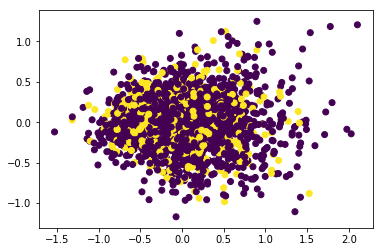

In [97]:
pca = PCA(n_components=2)
wtv_train_df_pca = pca.fit_transform(wtv_train_df)
plt.scatter(wtv_train_df_pca[:,0],wtv_train_df_pca[:,1],c=train_labels)
plt.show()

**Conclusion: Vectorizing the words in a matrix of word counts does not provide much predictive power, which is why most of our models based on word counts are predicting that most people will not get pizza, and have an AUC accuracy around 50% which is the same as a random guess. Next, we will attempt to engineer features from the text, and consider some of the numeric metadata.**

### 4.6 Analyze Numeric Metadata Features + Engineered Features from Request Text

In [29]:
# Feature engineering ideas
# (Ideas based on Stanford paper: How to Ask for a Favor: A Case Study on the Success of Altruistic Requests)

# 1. length of request - number of characters
# Take log transformation for a normal distribution

train_data['request_len_LOG'] = np.log10(train_data['request_title_and_text'].str.len() + 0.1)
dev_data['request_len_LOG'] = np.log10(dev_data['request_title_and_text'].str.len() + 0.1)
test_mini_data['request_len_LOG'] = np.log10(test_mini_data['request_title_and_text'].str.len() + 0.1)

# 2. Month of request (rather than timestamp)

train_data['request_month'] = train_data['unix_timestamp_of_request'].map(lambda x: datetime.datetime.fromtimestamp(x).month)
dev_data['request_month'] = dev_data['unix_timestamp_of_request'].map(lambda x: datetime.datetime.fromtimestamp(x).month)
test_mini_data['request_month'] = test_mini_data['unix_timestamp_of_request'].map(lambda x: datetime.datetime.fromtimestamp(x).month)

# 3. Day of week - i.e. maybe people are more likely to get pizza on friday rather than monday?

train_data['request_dayofweek'] = train_data['unix_timestamp_of_request'].map(lambda x: datetime.datetime.fromtimestamp(x).weekday())
dev_data['request_dayofweek'] = dev_data['unix_timestamp_of_request'].map(lambda x: datetime.datetime.fromtimestamp(x).weekday())
test_mini_data['request_dayofweek'] = test_mini_data['unix_timestamp_of_request'].map(lambda x: datetime.datetime.fromtimestamp(x).weekday())

# 4. Does request contain an image? (.jpeg, etc.)

imagelist = '.tif|.gif|.jpeg|.jpg|.jif|.png|.pdf'
train_data['contains_image'] = train_data['request_title_and_text'].str.contains(imagelist, case=False).astype(int)
dev_data['contains_image'] = dev_data['request_title_and_text'].str.contains(imagelist, case=False).astype(int)
test_mini_data['contains_image'] = test_mini_data['request_title_and_text'].str.contains(imagelist, case=False).astype(int)
#print('Total records:', len(train_data['contains_image']))
#print('Records with image:', sum(train_data['contains_image']))

# 5. Narrative for requesting pizza (Craving, Family, Job, Money, Student)

# Craving
craving_str = 'friend|girlfriend|craving|birthday|boyfriend|celebrate|party|game|games|movie|date|drunk|beer|celebrating|invited|drinks|crave|wasted|invite'
train_data['narr_craving'] = train_data['request_title_and_text'].str.contains(craving_str, case=False).astype(int)
dev_data['narr_craving'] = dev_data['request_title_and_text'].str.contains(craving_str, case=False).astype(int)
test_mini_data['narr_craving'] = test_mini_data['request_title_and_text'].str.contains(craving_str, case=False).astype(int)
# Family
family_str = 'family|mom|wife|parents|mother|husband|dad|son|daughter|father|parent|mum'
train_data['narr_family'] = train_data['request_title_and_text'].str.contains(family_str, case=False).astype(int)
dev_data['narr_family'] = dev_data['request_title_and_text'].str.contains(family_str, case=False).astype(int)
test_mini_data['narr_family'] = test_mini_data['request_title_and_text'].str.contains(family_str, case=False).astype(int)
# Job
job_str = 'work|job|paycheck|unemployment|interview|fired|employment|hired|hire'
train_data['narr_job'] = train_data['request_title_and_text'].str.contains(job_str, case=False).astype(int)
dev_data['narr_job'] = dev_data['request_title_and_text'].str.contains(job_str, case=False).astype(int)
test_mini_data['narr_job'] = test_mini_data['request_title_and_text'].str.contains(job_str, case=False).astype(int)
# Money
money_str = 'money|broke|week until|paid|account|rent|buy|bank|bill|cash|due soon|paycheck|check|spent|poor|financial|credit|budget|loan|bucks|deposit'
train_data['narr_money'] = train_data['request_title_and_text'].str.contains(money_str, case=False).astype(int)
dev_data['narr_money'] = dev_data['request_title_and_text'].str.contains(money_str, case=False).astype(int)
test_mini_data['narr_money'] = test_mini_data['request_title_and_text'].str.contains(money_str, case=False).astype(int)
# Student
student_str = 'college|student|school|roommate|studying|university|finals|semester|class|study|project|dorm|tuition'
train_data['narr_student'] = train_data['request_title_and_text'].str.contains(student_str, case=False).astype(int)
dev_data['narr_student'] = dev_data['request_title_and_text'].str.contains(student_str, case=False).astype(int)
test_mini_data['narr_student'] = test_mini_data['request_title_and_text'].str.contains(student_str, case=False).astype(int)

# 6. Does the request contain narrative that may suggest that they will pay the favor forward, or reciprocate?

payforward_str = 'pay it forward|paid it forward|will forward|will return|will pass|I will|repay|reciprocate'
train_data['narr_payforward'] = train_data['request_title_and_text'].str.contains(payforward_str, case=False).astype(int)
dev_data['narr_payforward'] = dev_data['request_title_and_text'].str.contains(payforward_str, case=False).astype(int)
test_mini_data['narr_payforward'] = test_mini_data['request_title_and_text'].str.contains(payforward_str, case=False).astype(int)
# print('Total records:', len(train_data['narr_payforward']))
# print('Records with pay forward:', sum(train_data['narr_payforward']))

In [30]:
# Numeric and binary features to use in models
numeric_features = [
'requester_account_age_in_days_at_request_LOG', 
'requester_days_since_first_post_on_raop_at_request_LOG', 
'requester_number_of_comments_at_request_LOG', 
'requester_number_of_comments_in_raop_at_request_LOG',
'requester_number_of_posts_at_request_LOG',
'requester_number_of_posts_on_raop_at_request_LOG',
'requester_number_of_subreddits_at_request_LOG', 
'requester_upvotes_minus_downvotes_at_request_LOG', 
'request_len_LOG',
'request_month',
'request_dayofweek',
'contains_image',
'narr_craving','narr_family','narr_job','narr_money','narr_student',
'narr_payforward'
]

In [100]:
# # Make sure there are no nan and infinite values before running model
# train_data[numeric_features].head()
# train_data[numeric_features].describe()

# np.any(np.isnan(train_data[numeric_features]))
# np.all(np.isfinite(train_data[numeric_features]))

# train_data[train_data[numeric_features].isnull().any(axis=1)][numeric_features]

##### Random Forests Model

In [31]:
# Random Forest
def randomForestClassifier(x_train, y_train, x_test, y_test, grid = 0):
    
    if grid == 1:
        
        parameters = { 
            'n_estimators' : list(np.arange(1000, 10000, 3000)),
            'max_leaf_nodes' : list(np.arange(10, 100, 30)),
            'criterion' : ['gini', 'entropy']
        }

        # perform gridsearch
        rnd_clf = GridSearchCV(RandomForestClassifier(), parameters)
        rnd_clf.fit(x_train, y_train)

        n_estimators = rnd_clf.best_params_['n_estimators']
        max_leaf_nodes = rnd_clf.best_params_['max_leaf_nodes']
        criterion = rnd_clf.best_params_['criterion']

        clf = RandomForestClassifier(n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes, criterion=criterion)
        
    else:
        
        clf = RandomForestClassifier()
        
    clf.fit(x_train, y_train)
    
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)*100.0
    
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)

    print ('Accuracy: {:2.5f}%'.format(accuracy))
    print ('Accuracy (AUC): {:2.5f}%'.format(metrics.auc(fpr,tpr) * 100))
    return y_pred

In [32]:
# Execute random forest model without gridsearch
print('----- Random Forests -----')
y_pred = randomForestClassifier(train_data[numeric_features],train_labels,
                                test_mini_data[numeric_features],test_mini_labels,grid=0)
print('Number of predictions:', len(y_pred))
print('Number predicted will get pizza:',sum(y_pred))
print('--------------------------')

----- Random Forests -----
Accuracy: 73.51485%
Accuracy (AUC): 51.60947%
Number of predictions: 808
Number predicted will get pizza: 66
--------------------------


In [103]:
# # Execute random forest model with gridsearch. (Run time approximately 10 minutes)
# print('----- Random Forests w/ tuned parameters -----')
# print(datetime.datetime.now())
# y_pred = randomForestClassifier(train_data[numeric_features],train_labels,test_mini_data[numeric_features],test_mini_labels,grid=1)
# print(datetime.datetime.now())
# print('Number of predictions:', len(y_pred))
# print('Number predicted will get pizza:',sum(y_pred))
# print('--------------------------')

##### Logistic Regression Model

In [33]:
# Logisitic modeling - numeric features
log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(dev_data[numeric_features], dev_labels)

log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(train_data[numeric_features], train_labels)
log_clf_best_predicted = log_clf_best.predict(test_mini_data[numeric_features])
fpr, tpr, _ = metrics.roc_curve(test_mini_labels, log_clf_best_predicted)

print('----- Logistic Regression -----')
print (log_gs.best_params_)
accuracy = accuracy_score(log_clf_best_predicted, test_mini_labels) * 100
print ('Logistic accuracy: {:2.5f}%'.format(accuracy))
print ('Logistic accuracy (AUC): {:2.5f}%'.format(metrics.auc(fpr,tpr) * 100))

print('Number of predictions:', len(log_clf_best_predicted))
print('Number predicted will get pizza:',sum(log_clf_best_predicted))
print('-----------------------------------')

----- Logistic Regression -----
{'C': 0.1}
Logistic accuracy: 77.97030%
Logistic accuracy (AUC): 53.58614%
Number of predictions: 808
Number predicted will get pizza: 20
-----------------------------------


##### Gaussian mixture model

In [34]:
def gmm(x_train, y_train, x_test, y_test, gmm_k, cv_type='full', to_print=True):

    # filter to positive or negative rows 
    train_p = x_train[y_train==True]
    p_labels = [y_train==True]
    train_n = x_train[y_train==False]
    n_labels = [y_train==False]
    
    # fit model on positive data points
    clf_p = mixture.GaussianMixture(n_components=gmm_k, covariance_type=cv_type).fit(train_p, p_labels)
    # fit model on negative data points
    clf_n = mixture.GaussianMixture(n_components=gmm_k, covariance_type=cv_type).fit(train_n, n_labels)
    
    # creaate prediction by taking the higher value for either model
    positive_pred = clf_p.score_samples(x_test)
    negative_pred = clf_n.score_samples(x_test)
    pred = positive_pred > negative_pred

    # calculating accuracy
    accuracy = sum(y_test == pred) / len(pred)
    
    fpr, tpr, _ = metrics.roc_curve(y_test, pred)
    
    if to_print==True:
        print ('Accuracy: {:2.5f}%'.format(accuracy))
        print ('Accuracy (AUC): {:2.5f}%'.format(metrics.auc(fpr,tpr) * 100))
        
    return pred

In [35]:
# GMM model
print('----- Gaussian mixture model -----')
y_pred = gmm(train_data[numeric_features],train_labels,
                                test_mini_data[numeric_features],test_mini_labels,gmm_k=4)
print('Number of predictions:', len(y_pred))
print('Number predicted will get pizza:',sum(y_pred))
print('--------------------------')

----- Gaussian mixture model -----
Accuracy: 0.63614%
Accuracy (AUC): 60.53878%
Number of predictions: 808
Number predicted will get pizza: 312
--------------------------


In [107]:
# GMM model with tuned paramters

print('----- Gaussian mixture model with tuned parameters-----')
gmm_components = range(1,25)
cv_types = ['spherical', 'diag', 'tied', 'full']

results = []

for cv_type in cv_types:
    for gmm_k in gmm_components:
        y_pred = gmm(train_data[numeric_features],train_labels,
                                test_mini_data[numeric_features],test_mini_labels, gmm_k=gmm_k, cv_type=cv_type, to_print=False)
        
        # Get accuracy of predictions
        accuracy = sum(test_mini_labels == y_pred) / len(y_pred)
        
        fpr, tpr, _ = metrics.roc_curve(test_mini_labels, y_pred)
        accuracy_auc = metrics.auc(fpr,tpr)
        
        results.append([cv_type, gmm_k, accuracy, sum(y_pred), accuracy_auc])
        
# Get parameters with best accuracy
best = results[np.argmax([x[4] for x in results])]

print('The best GMM model had an accuracy (AUC) of {}'.format(round(best[4],4)))
print('Covariance Type: {}'.format(best[0]))
print('GMM components: {}'.format(best[1]))
print('Number predicted will get pizza: {}'.format(best[3]))
print('--------------------------')

----- Gaussian mixture model with tuned parameters-----
The best GMM model had an accuracy (AUC) of 0.6222
Covariance Type: full
GMM components: 2
Number predicted will get pizza: 317
--------------------------


**Conclusion: Engineering features from the request text and using the numeric metadata improved the accuracy of the models. These models also predicted that people would receive pizza, which was not really happening when we relied on word counts. The Gaussian mixture model appears to give us the highest AUC accuracy of all models ran up to this point. In the next section, we will use Principal component analysis to convert the word counts we obtained in the previous section into a handful of components. We will combine these components with the features from this section.**

### 4.7 Analyze Numeric Metadata Features + Engineered Features from Request Text + Advanced Count Vectorizor

In [36]:
# creating our train/dev dfs to manipulate
train_df = train_data
dev_df = dev_data
mini_df = test_mini_data

# fixing the train index
train_df['my_index'] = range(train_df.shape[0])
train_df = train_df.set_index('my_index')
train_num_df = train_df[numeric_features]
train_txt_df = train_df['request_title_and_text']

# fixing the dev index
dev_df['my_index'] = range(dev_df.shape[0])
dev_df = dev_df.set_index('my_index')
dev_num_df = dev_df[numeric_features]
dev_txt_df = dev_df['request_title_and_text']

# fixing the mini index
mini_df['my_index'] = range(mini_df.shape[0])
mini_df = mini_df.set_index('my_index')
mini_num_df = mini_df[numeric_features]
mini_txt_df = mini_df['request_title_and_text']

# NLP to vectorize our text
vectorizer = CountVectorizer(analyzer=preprocess_text)
train_data_nlp = vectorizer.fit_transform(train_txt_df)
dev_data_nlp = vectorizer.transform(dev_txt_df)
mini_data_nlp = vectorizer.transform(mini_txt_df)

# using pca to change our sparse text matrix
pca = TruncatedSVD(n_components=50)
train_data_nlp_pca = pca.fit_transform(train_data_nlp)
dev_data_nlp_pca = pca.transform(dev_data_nlp)
mini_data_nlp_pca = pca.transform(mini_data_nlp)

nlp_pca_df = pd.DataFrame(data = train_data_nlp_pca)
dev_nlp_pca_df = pd.DataFrame(data = dev_data_nlp_pca)
mini_nlp_pca_df = pd.DataFrame(data = mini_data_nlp_pca)

train_data_all = pd.concat([train_num_df,nlp_pca_df],axis=1)
dev_data_all = pd.concat([dev_num_df,dev_nlp_pca_df],axis=1)
mini_data_all = pd.concat([mini_num_df,mini_nlp_pca_df],axis=1)

##### Random Forests Model

In [37]:
# Execute random forest model without gridsearch
print('----- Random Forests -----')
y_pred = randomForestClassifier(train_data_all,train_labels,
                                mini_data_all,test_mini_labels,grid=0)
print('Number of predictions:', len(y_pred))
print('Number predicted will get pizza:',sum(y_pred))
print('--------------------------')

----- Random Forests -----
Accuracy: 75.99010%
Accuracy (AUC): 52.48113%
Number of predictions: 808
Number predicted will get pizza: 38
--------------------------


##### Logistic Regression Model

In [38]:
# Logisitic modeling - numeric features + count vectorizor

log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(dev_data_all, dev_labels)

log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(train_data_all, train_labels)
log_clf_best_predicted = log_clf_best.predict(mini_data_all)
fpr, tpr, _ = metrics.roc_curve(test_mini_labels, log_clf_best_predicted)

print('----- Logistic Regression -----')
print (log_gs.best_params_)
accuracy = accuracy_score(log_clf_best_predicted, test_mini_labels) * 100
print ('Logistic accuracy: {:2.3f}%'.format(accuracy))
print ('Logistic accuracy (AUC): {:2.3f}%'.format(metrics.auc(fpr,tpr) * 100))

print('Number of predictions:', len(log_clf_best_predicted))
print('Number predicted will get pizza:',sum(log_clf_best_predicted))
print('-----------------------------------')

----- Logistic Regression -----
{'C': 0.001}
Logistic accuracy: 76.609%
Logistic accuracy (AUC): 49.919%
Number of predictions: 808
Number predicted will get pizza: 1
-----------------------------------


**Conclusion: AUC accuracy appears to decline when we add in PCA of 50 components of our matrix of word counts into the models we created in the last section based on numeric metadata and engineered features from the request text. This seems to continue to support the idea that word counts do not provide any predictive power in this dataset. It also shows that including the word counts as predictors along with other features with more preditive power can actually hurt the models.**

### 5. Conclusion

**Applying a Gaussian mixture model with tuned parameters to the log transformed numeric metadata provided in the original dataset + additional features we engineered from the request title and text, resulted in the best AUC accuracy of roughly 62%.**